In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from data import Dataset
from models.deblur import Deblur
from loss_function import Loss
from optimizers import Optimizers
from plots_easy import PlotsEasy
from msg_alert import MsgAlert

2023-07-28 21:46:46.570070: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
#alert = MsgAlert()

In [3]:

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# Get the list of physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

# Set memory growth for each physical GPU (if available)
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-07-28 21:46:51.882946: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-28 21:46:51.885151: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-28 21:46:51.932492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-28 21:46:51.932963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.78GiB deviceMemoryBandwidth: 245.91GiB/s
2023-07-28 21:46:51.933026: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-07-28 21:46:51.937997: I tensorflow/stream_executor/platform/defa

In [4]:
dataset = Dataset(buffer_size=400, batch_size=1 )

2023-07-28 21:46:51.988877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 21:46:51.991132: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-28 21:46:51.991622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-28 21:46:51.992110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.78GiB deviceMemoryBandwidth: 245.91GiB

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [5]:
ssim_vals = PlotsEasy(xlabel='Step', ylabel='SSIM', title='Step X SSIM')
errors = PlotsEasy(xlabel='Step', ylabel='loss_error', title='Step X Loss_error')
mse = PlotsEasy(xlabel='Step', ylabel='Mse', title='Step X Mse')

In [57]:
def view_images(model, test_input, tar, epoch=1):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    ssim_rs = tf.image.ssim(tar, prediction, max_val=1.0)
    ssim_vals.append(epoch,ssim_rs.numpy())
    
    mse_error = tf.reduce_mean(tf.keras.losses.mean_squared_error(tar, prediction))
    mse.append(epoch,mse_error.numpy())
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        
        # Convert to integers in the range [0, 255]
        clipped_image = np.clip((display_list[i] + 1) * 0.5, 0, 1)
        int_image = (clipped_image * 255).astype(np.uint8)
        plt.imshow(int_image)
        
        plt.axis('off')

    plt.suptitle(f"Result - Epoch {epoch}", fontsize=16)
    plt.plot()
    plt.savefig('./imgs_for_send/temp_result.png')
    plt.clf()
    plt.close()

    ssim_vals.save('./imgs_for_send/ssim_results.png')
    errors.save('./imgs_for_send/loss_results.png')
    mse.save('./imgs_for_send/mse_results.png')

In [39]:
def view_images_v2(model, test_input, tar, epoch=1):
    prediction = model(test_input, training=True)
    print( tf.image.ssim(predict, tar_batch, max_val=1.0) )
    print(  tf.losses.mean_squared_error(tar_batch,predict) )
    print( tf.image.psnr(predict, tar_batch, max_val=1.0) )

In [7]:
# def save_error(epoc, error):
#     errors.append(epoc, error)

In [8]:
def get_image_paths(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            image_paths.append(os.path.join(directory, filename))
    return image_paths

In [9]:
# def send_update(epoch):
#     alert.send_msg(msg="Hey chefe, aqui suas atualizações")

#     for path in get_image_paths('./imgs_for_send'):
#         name = path.split('/')[-1]
#         alert.send_msg(msg=name, image_path=path)

In [10]:
try:
    loss = Loss('mse_loss_v2').loss_function
    optimazer = Optimizers(name_opt='Adam', learning_rate=0.00046415888336127773, beta_1=0.95, beta_2=0.99).optimizer
    net = Deblur()
    checkpoint_dir = './training_checkpoints'
    net.compile(
            otimazer_generator=optimazer,
            loss_generator=loss,
            checkpoint_dir=checkpoint_dir
            )
except:
    print("Error")
#     alert.send_msg(msg='Ocorreu um error')
    
# alert.send_msg(msg='Inicio da execução')

In [11]:
try:
    net.fit(dataset.train, dataset.test, steps=50000, view_callback=view_images)
    net.generator.save('model_result.h5')
except:
    print('error')
#     alert.send_msg(msg='Ocorreu um error durante o treinamento')

# alert.send_msg(msg='Fim da execução')

Step: 49k
.Avaliando modelo
tf.Tensor(nan, shape=(), dtype=float32) tf.Tensor(nan, shape=(), dtype=float32) tf.Tensor(nan, shape=(), dtype=float32)


In [58]:
ssim_total = []
mse_total = []
psnr_total = []
for inp_batch, tar_batch in dataset.test.take(1):
    view_images(net.generator,inp_batch, tar_batch)

In [35]:
psnr_total

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [13]:
tf.reduce_mean(ssim_total).numpy()

nan

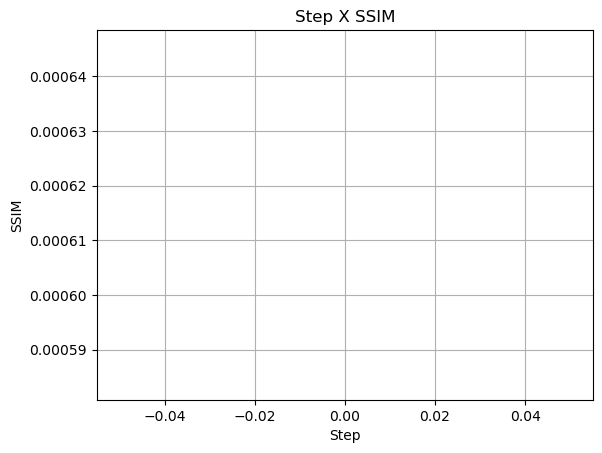

In [9]:
ssim_vals.plot()

In [41]:
loaded_model = tf.keras.models.load_model('/home/natanael/deblurring_images/model_result.h5')

In [49]:

example_input, example_target = next(iter(dataset.test.take(1)))

loaded_model(example_target,  training=False)

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        ...,

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, n

In [59]:
view_images(loaded_model,example_input, example_target)

In [50]:
print(loaded_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________